In [23]:
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import numpy as np
import random
import matplotlib.pyplot as plt

In [14]:
def randConnect(n):
    n += 1
    tran = np.zeros((n,n))
    time = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if(i == j):
                continue
            t1 = random.randrange(400,500)
            tran[i,j] = t1
            tran[j,i] = t1
            t2 = random.randrange(20,200)
            time[i,j] = t2
            time[j,i] = t2
    return(tran)

In [3]:
#tc = randConnect(17)

In [58]:
def create_data_model(n, m):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = randConnect(n)
    '''
    data['distance_matrix'] = [
        [
            0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354,
            468, 776, 662
        ],
        [
            548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674,
            1016, 868, 1210
        ],
        [
            776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164,
            1130, 788, 1552, 754
        ],
        [
            696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822,
            1164, 560, 1358
        ],
        [
            582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708,
            1050, 674, 1244
        ],
        [
            274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628,
            514, 1050, 708
        ],
        [
            502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856,
            514, 1278, 480
        ],
        [
            194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320,
            662, 742, 856
        ],
        [
            308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662,
            320, 1084, 514
        ],
        [
            194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388,
            274, 810, 468
        ],
        [
            536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764,
            730, 388, 1152, 354
        ],
        [
            502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114,
            308, 650, 274, 844
        ],
        [
            388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194,
            536, 388, 730
        ],
        [
            354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0,
            342, 422, 536
        ],
        [
            468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536,
            342, 0, 764, 194
        ],
        [
            776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274,
            388, 422, 764, 0, 798
        ],
        [
            662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730,
            536, 194, 798, 0
        ],
    ]
    '''
    
    data['pickups_deliveries'] = [
        [1, 6],
        [2, 10],
        [4, 3],
        [5, 9],
        [7, 8],
        #[15, 11],
        #[13, 12],
        #[16, 14],
        #[19, 17],
        #[22,29],
        #[28,20],
        #[26, 24],
    ]
    data['num_vehicles'] = m
    data['depot'] = 0
    return data

In [59]:
def print_solution(data, manager, routing, assignment):
    total_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = assignment.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        total_distance += route_distance
    print('Total Distance of all routes: {}m'.format(total_distance))
    return total_distance

In [60]:
def tabuSearch():
    n = 10 # no. of nodes
    m = 4 # no. of vehicles
    data = create_data_model(n, m)
    data['num_vehicles'] = m
    
    manager = pywrapcp.RoutingIndexManager(
        len(data['distance_matrix']), data['num_vehicles'], data['depot'])

    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  
        3000,  # vehicle maximum travel distance
        True,
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Define Transportation Requests.
    for request in data['pickups_deliveries']:
        pickup_index = manager.NodeToIndex(request[0])
        delivery_index = manager.NodeToIndex(request[1])
        routing.AddPickupAndDelivery(pickup_index, delivery_index)
        routing.solver().Add(
            routing.VehicleVar(pickup_index) == routing.VehicleVar(
                delivery_index))
        routing.solver().Add(
            distance_dimension.CumulVar(pickup_index) <=
            distance_dimension.CumulVar(delivery_index))

    # routing_tabu_search 
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH)
    search_parameters.time_limit.seconds = 30
    search_parameters.log_search = True
    #search_parameters.first_solution_strategy = (
    #   routing_enums_pb2.FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION)
    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)
    if assignment:
        td = print_solution(data, manager, routing, assignment)
    return(td)


#if __name__ == '__main__':
#    main()

In [15]:
tabuSearch()

Route for vehicle 0:
 0 ->  4 ->  2 ->  3 -> 0
Distance of the route: 1666m

Route for vehicle 1:
 0 ->  10 ->  5 ->  9 -> 0
Distance of the route: 1662m

Route for vehicle 2:
 0 ->  7 ->  8 -> 0
Distance of the route: 1361m

Route for vehicle 3:
 0 ->  1 ->  6 -> 0
Distance of the route: 1355m

Total Distance of all routes: 6044m


6044

In [49]:
cost = []

In [50]:
for i in range(5):
    cost.append(tabuSearch())
    print("-------------------------")

Route for vehicle 0:
 0 ->  15 ->  21 ->  11 ->  25 -> 0
Distance of the route: 2136m

Route for vehicle 1:
 0 ->  4 ->  5 ->  9 ->  3 -> 0
Distance of the route: 2145m

Route for vehicle 2:
 0 ->  26 ->  24 -> 0
Distance of the route: 1387m

Route for vehicle 3:
 0 ->  27 ->  22 ->  29 ->  23 -> 0
Distance of the route: 2154m

Route for vehicle 4:
 0 ->  1 ->  2 ->  6 ->  10 -> 0
Distance of the route: 2155m

Route for vehicle 5:
 0 ->  18 ->  19 ->  17 ->  30 -> 0
Distance of the route: 2124m

Route for vehicle 6:
 0 ->  7 ->  16 ->  8 ->  14 -> 0
Distance of the route: 2123m

Route for vehicle 7:
 0 ->  13 ->  28 ->  12 ->  20 -> 0
Distance of the route: 2111m

Total Distance of all routes: 16335m
-------------------------
Route for vehicle 0:
 0 ->  22 ->  21 ->  29 ->  25 -> 0
Distance of the route: 2107m

Route for vehicle 1:
 0 ->  1 ->  26 ->  6 ->  24 -> 0
Distance of the route: 2120m

Route for vehicle 2:
 0 ->  19 ->  7 ->  8 ->  17 -> 0
Distance of the route: 2119m

Route f

In [19]:
cost

[6182, 6219, 6136, 5999, 6318]

In [20]:
for i in range(5):
    cost.append(tabuSearch())
    print("-------------------------")

Route for vehicle 0:
 0 ->  7 ->  2 ->  8 -> 0
Distance of the route: 1732m

Route for vehicle 1:
 0 ->  5 ->  9 -> 0
Distance of the route: 1424m

Route for vehicle 2:
 0 ->  10 ->  1 ->  6 -> 0
Distance of the route: 1633m

Route for vehicle 3:
 0 ->  4 ->  3 -> 0
Distance of the route: 1352m

Total Distance of all routes: 6141m
-------------------------
Route for vehicle 0:
 0 ->  1 ->  6 -> 0
Distance of the route: 1325m

Route for vehicle 1:
 0 ->  7 ->  2 ->  8 -> 0
Distance of the route: 1758m

Route for vehicle 2:
 0 ->  5 ->  9 -> 0
Distance of the route: 1414m

Route for vehicle 3:
 0 ->  4 ->  10 ->  3 -> 0
Distance of the route: 1703m

Total Distance of all routes: 6200m
-------------------------
Route for vehicle 0:
 0 ->  2 ->  5 ->  9 -> 0
Distance of the route: 1760m

Route for vehicle 1:
 0 ->  10 ->  1 ->  6 -> 0
Distance of the route: 1718m

Route for vehicle 2:
 0 ->  7 ->  8 -> 0
Distance of the route: 1420m

Route for vehicle 3:
 0 ->  4 ->  3 -> 0
Distance of the

In [51]:
cost

[16335, 16084, 16250, 16281, 16644]

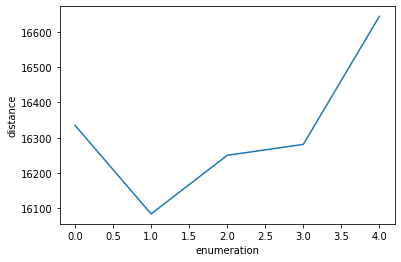

In [52]:
plt.xlabel('enumeration')
plt.ylabel('distance')
plt.plot(cost, label = "Cost in 10 enumerations")

In [53]:
avg = np.mean(cost)

In [54]:
err = []

In [55]:
for i in range(len(cost)):
    err.append(abs(cost[i]-avg))

In [56]:
err

[16.200000000000728,
 234.79999999999927,
 68.79999999999927,
 37.79999999999927,
 325.2000000000007]

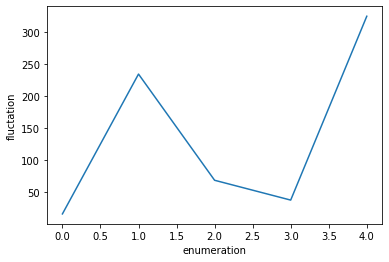

In [57]:
plt.xlabel('enumeration')
plt.ylabel('fluctation')
plt.plot(err, label = "Fluctation in 10 enumerations")